### Выполнил Евгений Гузеев

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# Библиотека регулярных выражений
import re

In [2]:
# Загрузим данные с неуникальными значениями
df_nunique = pd.read_excel('best_analysis (ДИПЛОМ).xlsx', index_col=0)[['description', 'activity', 'name', 'screen_name']]
# Выведем первые 5 занчений
df_nunique.head(5)

,description,activity,name,screen_name
0,"Присылайте свои анекдоты в ""Предложите новость...",Юмор,Азохнвей! Бесплатные щикарные анекдоты,azohen_vey
1,"Познавательные мемы, широкий охват тем, уникал...",Юмор,Мемуары ценителей научных мемов,sciencemem
2,На Хабр Q&A можно получить ответ на вопрос по ...,Программирование,Хабр Q&A,toster_ru
3,Официальный канал сервиса РБК Инвестиции для т...,Финансы,РБК Инвестиции,rbc_investments
4,"Помогаем новичкам стать веб-разработчиками, а ...",Программирование,Хекслет,hexlet


In [3]:

print(f'Датафрейм с данными по прикладной информатике имеет {df_nunique.shape[0]} строк и {df_nunique.shape[1]} столбца' )

Датафрейм с данными по прикладной информатике имеет 7863 строк и 4 столбца


In [4]:
# Посмотрим на соотношение уникальных значений и неуникальных
# Для этого сделаем небольшой датафрейм и отобразим его визуально
df_all = pd.DataFrame({'Значения' : ['уникальные', 'неуникальные'],
                      'Количество' : [len(df_nunique['name'].unique()),
                                     df_nunique.shape[0] - len(df_nunique['name'].unique())]})
df_all = df_all.set_index('Значения').reset_index()
df_all['Процентное_соотношение'] = np.round(100 * df_all['Количество'] / len(df_nunique), 2)
df_all = df_all[['Значения', 'Процентное_соотношение']].set_index('Значения')
df_all

,Процентное_соотношение
Значения,
уникальные,54.5
неуникальные,45.5


Text(0.5, 1.0, 'Соотношение Уникальных и неуникальных значений')

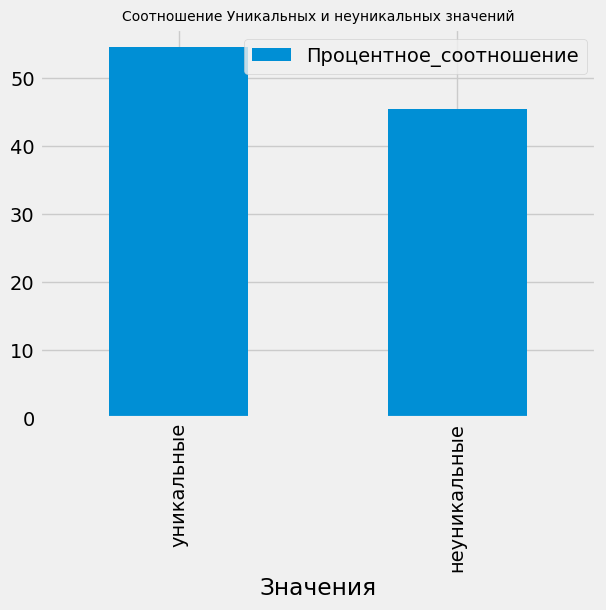

In [5]:
df_all.plot.bar()
plt.title('Соотношение Уникальных и неуникальных значений', size=10)

### Предположение 1:

Люди, которые увлечены аналитикой данных, программированием интересуются следующим:

* Обычные сми, юморы, мемы, демотиваторы (нельзя почти изъять полезную информацию)
* Для разгрузки головы и развития другого полушария используются видеоигры, просмотры стримов, игра на гитаре, психология итд
* Английский и увлечение языком, позволяет становится профессиональнее
* Программирование математика

In [6]:
# Путем подсчета занчений проверим это соотношение
df_nun_value = pd.DataFrame(df_nunique['name'].value_counts()).head(30)
df_nun_value

,name
Лентач,123
Пикабу,80
Типичный программист,44
/dev/null,44
Хабр,44
Наука и Техника,43
MDK,42
Мои любимые юморески,40
Лепра,38
хайер скул оф мемс,37


### Исходя из этих данных целесообразно делить на 4 класса:

1. Читалка, интернет-сми, юмор, обьявления, философия
2. Все что относится к хобби
3. Движение к развитию человека (математика, английский, дизайн итд)
4. Развитие профессиональных софт скиллов ( Все что отнсоится к программированию)

Для алгоритма градиентного бустинга `CatBoost`, не надо проводить предообработку текста, кроме чистки. Лематизация и токенизация встроен в сам алгоритм.

Для всех других алгоритмов необходимо сделать все шаги препроцессинга и перевести текст в векторное представление `TFiDF` 

## Загрузим размеченные данные

In [7]:
# Загрузим данные для классификации
df = pd.read_excel('diploma_this.xlsx')
# сделаем копию датафрейма
df1 = df.copy()
# Выведем первые 10 значений
df1.head(5)

,description,activity,name,screen_name,target
0,"Присылайте свои анекдоты в ""Предложите новость...",Юмор,Азохнвей! Бесплатные щикарные анекдоты,azohen_vey,1
1,"Познавательные мемы, широкий охват тем, уникал...",Юмор,Мемуары ценителей научных мемов,sciencemem,1
2,На Хабр Q&A можно получить ответ на вопрос по ...,Программирование,Хабр Q&A,toster_ru,4
3,Официальный канал сервиса РБК Инвестиции для т...,Финансы,РБК Инвестиции,rbc_investments,3
4,"Помогаем новичкам стать веб-разработчиками, а ...",Программирование,Хекслет,hexlet,4


In [8]:
# Посмотрим на количество пропущенных занчений
df.isna().mean()

description    0.159221
activity       0.006873
name           0.000229
screen_name    0.000000
target         0.000000
dtype: float64

Как видим в столбцах `description`, `activity`, `name` имеются пропущенные значения. Так как на этих данных будет происходить обучение модели, то более целесообразнее не удалять пустые значения, а заменить их например на строку `пустое название`

In [9]:
# Посмотрим на соотношение классов
df_target = pd.DataFrame(100 * df1['target'].value_counts(normalize=True))
df_target

,target
1,52.279496
2,37.021764
3,7.308133
4,3.390607


Text(0.5, 1.0, 'Разбиение классов')

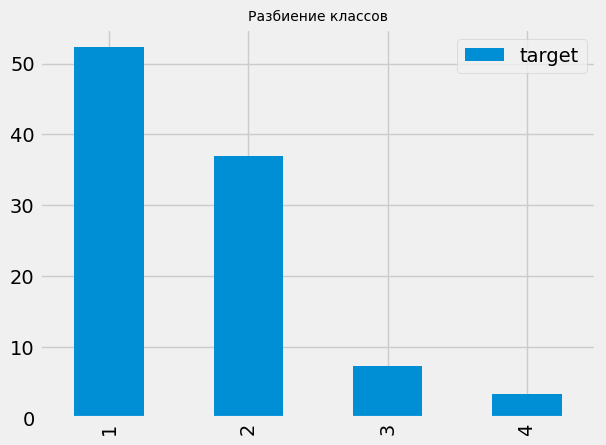

In [10]:
df_target.plot.bar()
plt.title('Разбиение классов', size=10)

Как видим из графика классы очень сильно не сбалансированы. В случае несбалансированности классов целесообразнее использовать метрику `Total F`

Мера **F-Score** представляет собой гармоническое среднее точности и полноты, то есть обратное значение	от среднего	значения обратных значений точности	и полноты

$$ F = 2 \cdot {\frac{точность \cdot полнота}{точность + полнота}} $$

Здесь	стоит	отметить,	что	точность	и полнота	являются	«естественными»	обратными	величинами	в том	смысле,	что	у них	одинаковый	числитель	(количество	истинно	положительных	случаев),	а знаменатели	различны.	

### Напишем функцию препроцессинга текстовых данных

Некоторые слова не несут смысловую нагрузку. К таким словам также можно отнести союзы, предлоги, а также знаки препинания. Для экономии времени воспользуемся готовым набором стоп слов

Подготовка текста для обучения состоит из нескольких этапов:
    
 1. Чистка текста, удаление стоп слов, удаление пунктуации. Замена пустых значений.
 2. Токенизация текста - разбиение текста на токены
 3. Лематизация текста - приведение слова к нормальному типу. Например слово `присылайте` измениться на слово `присылать`
 4. Разбиение на тестовую и обучающую выборку.
    


In [11]:
# Фильтр стоп слов
# Загрузим стоп слова
with open ("stopwords-ru.txt", encoding='utf-8') as stop_ru:
    rus_stops = [word.strip() for word in stop_ru.readlines()]
punctuation = '!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~—»«...–'    
filter = rus_stops + list(punctuation)
# Выведем часть значений из фильтра
filter[:5]

['c', 'а', 'алло', 'без', 'белый']

In [12]:
# Импорт лематизатора
from pymorphy2 import MorphAnalyzer
parser = MorphAnalyzer()

In [13]:
from nltk.tokenize import word_tokenize        # Импорт токенезации слов
#from nltk import download as nltk_download     # Паке с токенизатором

#nltk_download("punkt")

In [14]:
def text_preprocess1(input_text):
    # Удалим все гиперссылки
    text = re.sub(r"https?://[^,\s]+,?", "", input_text)
    # Удалим все цифры
    text = re.sub(r'\d', '', text)
    # Приведем к нижнему регистру
    text = text.lower()
    # Удалим все переносы
    text = text.replace('\n', ' ')
    # Удалим все смайлики
    text = re.sub('[^\x00-\x7Fа-яА-Я]', '', text)
    # Удалим все спецсимволы
    text = re.sub(r"[^a-zA-Z0-9а-яА-Я]", " ", text)
    
    # удалим id
    text = text.replace('id', '')
    # Удалим более одного пробела
    text = re.sub(r'\s+ ', ' ', text)
    tokenized_text = word_tokenize(text)
    clean_text = [word for word in tokenized_text if word not in filter]
    lemmatized_text = [parser.parse(word)[0].normal_form for word in 
                       clean_text]
    lemmatized_text = ' '.join(lemmatized_text)
    
    return lemmatized_text
    

In [15]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4365 entries, 0 to 4364
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  3670 non-null   object
 1   activity     4335 non-null   object
 2   name         4364 non-null   object
 3   screen_name  4365 non-null   object
 4   target       4365 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 170.6+ KB


In [16]:
df1 = df1.fillna('Пустое название')
df1['description_processed'] = df1['description'].astype('str').map(text_preprocess1)
df1['activity_processed'] = df1['activity'].astype('str').map(text_preprocess1)
df1['name_processed'] = df1['name'].astype('str').map(text_preprocess1)

In [17]:
df1.head(3)

,description,activity,name,screen_name,target,description_processed,activity_processed,name_processed
0,"Присылайте свои анекдоты в ""Предложите новость...",Юмор,Азохнвей! Бесплатные щикарные анекдоты,azohen_vey,1,присылать анекдот предложить новость группа ре...,юмор,азохнвеять бесплатный щикарный анекдот
1,"Познавательные мемы, широкий охват тем, уникал...",Юмор,Мемуары ценителей научных мемов,sciencemem,1,познавательный мем широкий охват уникальный ид...,юмор,мемуары ценитель научный мем
2,На Хабр Q&A можно получить ответ на вопрос по ...,Программирование,Хабр Q&A,toster_ru,4,хабра q a ответ любой тема it участник сообщес...,программирование,хабра q a


In [163]:
# Создадим датафрейм с предобработанными данными
df2 = df1[['description_processed', 'activity_processed', 'name_processed', 'target']].copy()
df2.head(3)

,description_processed,activity_processed,name_processed,target
0,присылать анекдот предложить новость группа ре...,юмор,азохнвеять бесплатный щикарный анекдот,1
1,познавательный мем широкий охват уникальный ид...,юмор,мемуары ценитель научный мем,1
2,хабра q a ответ любой тема it участник сообщес...,программирование,хабра q a,4


Данный датафрейм будет использоваться для градиентного бустинга `CatBoost` без настройки гиперпараметров. Модель обучим на следующих данных, так чтобы по итогу у нас получилось три модели:

1. Разобьем данные на **train** и **test**. В pool укажем какие данные в нашей задаче текстовые и категориальные данные
2. Склеим все текстовое признаковое пространство чтобы в результате получилось две колонки...**text_features** и **target** 
3. Преобразуем **text_features**​ в TFiDF и обучим модель


## Catboost

In [19]:
from catboost import CatBoostClassifier
from catboost import Pool
#имортируем функцию, позволяющую делить выборку на тестовую и тренировочную в случайном порядке:
from sklearn.model_selection import train_test_split 

## 1 модель ( Указываем текстовые и категориальные признаки)

In [20]:
from catboost import CatBoostClassifier
from catboost import Pool

In [21]:
#имортируем функцию, позволяющую делить выборку на тестовую и тренировочную в случайном порядке:
from sklearn.model_selection import train_test_split
# Классификационные метрики
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix # функция для визуализации матрицы ошибок

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop('target', axis=1), 
                                                    df2['target'], test_size=.3, 
                                                    random_state=7575)

In [23]:
# Указываем признаки
# Текстовые и категориальные признаки
text_features = ['description_processed','name_processed']
cat_features = ['activity_processed']

In [36]:
# Функция для обучения модели
def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostClassifier(
        depth = 8,
        iterations=5000,
        learning_rate=0.02,
        eval_metric='TotalF1', #'Accuracy'
        task_type='GPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )


In [37]:
train_pool = Pool(
    X_train, y_train,
    text_features=text_features,
    cat_features=cat_features
)

validation_pool = Pool(
    X_test, y_test,
    text_features=text_features,
    cat_features=cat_features
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model = fit_model(train_pool, validation_pool)

Train dataset shape: (3055, 3)

0:	learn: 0.4664806	test: 0.4811024	best: 0.4811024 (0)	total: 25.1ms	remaining: 2m 5s
100:	learn: 0.7114426	test: 0.7177704	best: 0.7177704 (95)	total: 2.14s	remaining: 1m 43s
200:	learn: 0.7304742	test: 0.7320854	best: 0.7320854 (198)	total: 4.17s	remaining: 1m 39s
300:	learn: 0.7433512	test: 0.7369351	best: 0.7369351 (296)	total: 6.11s	remaining: 1m 35s
400:	learn: 0.7517889	test: 0.7388020	best: 0.7394020 (386)	total: 8.07s	remaining: 1m 32s
500:	learn: 0.7657845	test: 0.7395813	best: 0.7421414 (470)	total: 9.99s	remaining: 1m 29s
600:	learn: 0.7733862	test: 0.7401409	best: 0.7423179 (517)	total: 11.9s	remaining: 1m 27s
700:	learn: 0.7848993	test: 0.7402999	best: 0.7423179 (517)	total: 13.9s	remaining: 1m 25s
800:	learn: 0.7894286	test: 0.7412648	best: 0.7450618 (758)	total: 15.8s	remaining: 1m 22s
900:	learn: 0.7970717	test: 0.7450210	best: 0.7450863 (881)	total: 17.7s	remaining: 1m 20s
1000:	learn: 0.8020417	test: 0.7429969	best: 0.7450933 (908)	to

In [26]:
# Посчитаем предсказанные значения на тестовой выборке
y_preds_catb_model_0 = model.predict(X_test)

In [27]:
print('Модель с указанием текстовых и категориальных признаков')
print(classification_report(y_test, y_preds_catb_model_0))

Модель с указанием текстовых и категориальных признаков
              precision    recall  f1-score   support

           1       0.86      0.82      0.84       714
           2       0.69      0.80      0.74       458
           3       0.64      0.45      0.53       100
           4       0.59      0.42      0.49        38

    accuracy                           0.77      1310
   macro avg       0.70      0.62      0.65      1310
weighted avg       0.78      0.77      0.77      1310



In [39]:
f1_score_catb_model_0 = f1_score(y_test, y_preds_catb_model_0, average='weighted')
f1_score_catb_model_0

0.7709773916786413

## 2 модель (Делаем склейку всего признакового пространства)

In [164]:
# Создадим новый датафрейм путем склеивания текстовых данных
df3 = df2.copy()
df3['text_features'] = df3['description_processed'] + ' ' + df3['activity_processed'] + ' ' + df3['name_processed']
df3 = df3[['text_features', 'target']]
df3.head(3)

,text_features,target
0,присылать анекдот предложить новость группа ре...,1
1,познавательный мем широкий охват уникальный ид...,1
2,хабра q a ответ любой тема it участник сообщес...,4


In [159]:
# Разбиваем на train и test
X_train, X_test, y_train, y_test = train_test_split(df3.drop('target', axis=1), 
                                                    df3['target'], test_size=.3, 
                                                    random_state=7575)

In [41]:


# Указываем на текстовые признаки
text_features = ['text_features']
cat_features = []

# Обучаем модель
train_pool = Pool(
    X_train, y_train,
    text_features=text_features,
    cat_features=cat_features
)

validation_pool = Pool(
    X_test, y_test,
    text_features=text_features,
    cat_features=cat_features
)


print('Train dataset shape: {}\n'.format(train_pool.shape))
model_1_catb = fit_model(train_pool, validation_pool)

Train dataset shape: (3055, 1)

0:	learn: 0.6829228	test: 0.6942847	best: 0.6942847 (0)	total: 36.5ms	remaining: 3m 2s
100:	learn: 0.7073286	test: 0.7131382	best: 0.7162491 (47)	total: 2.64s	remaining: 2m 8s
200:	learn: 0.7315454	test: 0.7254776	best: 0.7271390 (197)	total: 4.99s	remaining: 1m 59s
300:	learn: 0.7416463	test: 0.7265197	best: 0.7288261 (209)	total: 7.28s	remaining: 1m 53s
400:	learn: 0.7532649	test: 0.7326465	best: 0.7334224 (399)	total: 9.54s	remaining: 1m 49s
500:	learn: 0.7648766	test: 0.7352161	best: 0.7359323 (470)	total: 11.7s	remaining: 1m 45s
600:	learn: 0.7769967	test: 0.7379584	best: 0.7389148 (583)	total: 13.9s	remaining: 1m 41s
700:	learn: 0.7861446	test: 0.7412717	best: 0.7434364 (668)	total: 16.1s	remaining: 1m 38s
800:	learn: 0.7920240	test: 0.7451780	best: 0.7458964 (771)	total: 18.3s	remaining: 1m 35s
900:	learn: 0.7985455	test: 0.7476998	best: 0.7484190 (896)	total: 20.4s	remaining: 1m 33s
1000:	learn: 0.8051159	test: 0.7471101	best: 0.7484190 (896)	tot

In [42]:
# Посчитаем предсказанные значения на тестовой выборке
y_preds_catb_model_1 = model_1_catb.predict(X_test)
print('Модель со склееными текстовыми признаками')
print(classification_report(y_test, y_preds_catb_model_1))

Модель со склееными текстовыми признаками
              precision    recall  f1-score   support

           1       0.83      0.80      0.82       714
           2       0.69      0.76      0.72       458
           3       0.57      0.47      0.52       100
           4       0.70      0.55      0.62        38

    accuracy                           0.75      1310
   macro avg       0.70      0.65      0.67      1310
weighted avg       0.76      0.75      0.75      1310



In [43]:
f1_score_catb_model_1 = f1_score(y_test, y_preds_catb_model_1, average='weighted')
f1_score_catb_model_1

0.7532876276200994

## 3 модель (TFiDF) CatBoost

Для использования этой модели будет использован датафрейм **df3**. Текстовые признаки будут трансофрмированы в числовое векторное пространство. После этого разобьем на train и test.
Так как все предложения разной длины и изначально разбить их нельзя.

Также, полученным новым признаковым пространством будем пользоваться для других алгоритмов

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Создадим корпус текста
corpus = df3['text_features'].values
# Используем векторизатор
vectorizer = TfidfVectorizer(min_df=1)
# Трансформируем данные
modeltf = vectorizer.fit_transform(corpus)

In [143]:
# Проведем разбивку на train и test
X_train, X_test, y_train, y_test = train_test_split(modeltf, df3['target'].values, test_size=.3, 
                                                    random_state=7575, stratify =df3['target'].values)

In [103]:
# Обучаем модель
# Указываем на текстовые признаки
text_features = []
cat_features = []

# Обучаем модель
train_pool = Pool(
    X_train, y_train,
    text_features=text_features,
    cat_features=cat_features
)

validation_pool = Pool(
    X_test, y_test,
    text_features=text_features,
    cat_features=cat_features
)


print('Train dataset shape: {}\n'.format(train_pool.shape))
model_2_catb = fit_model(train_pool, validation_pool)

Train dataset shape: (3055, 23464)

0:	learn: 0.5428342	test: 0.5305243	best: 0.5305243 (0)	total: 297ms	remaining: 24m 44s
100:	learn: 0.6736378	test: 0.6351370	best: 0.6377341 (97)	total: 9.56s	remaining: 7m 43s
200:	learn: 0.7274150	test: 0.6774922	best: 0.6775688 (197)	total: 18.6s	remaining: 7m 23s
300:	learn: 0.7511648	test: 0.6947122	best: 0.6962476 (298)	total: 27.7s	remaining: 7m 12s
400:	learn: 0.7719236	test: 0.7057728	best: 0.7073029 (398)	total: 36.3s	remaining: 6m 56s
500:	learn: 0.7908115	test: 0.7109980	best: 0.7116218 (493)	total: 44.5s	remaining: 6m 39s
600:	learn: 0.8073993	test: 0.7146038	best: 0.7160188 (586)	total: 52.7s	remaining: 6m 25s
700:	learn: 0.8161508	test: 0.7204182	best: 0.7211057 (696)	total: 1m	remaining: 6m 11s
800:	learn: 0.8274048	test: 0.7233594	best: 0.7233594 (800)	total: 1m 8s	remaining: 5m 58s
900:	learn: 0.8321305	test: 0.7223525	best: 0.7240105 (809)	total: 1m 16s	remaining: 5m 45s
1000:	learn: 0.8372644	test: 0.7235811	best: 0.7241318 (985)

In [104]:
# Посчитаем предсказанные значения на тестовой выборке
y_preds_catb_model_2 = model_2_catb.predict(X_test)
print('Модель со склееными текстовыми признаками')
print(classification_report(y_test, y_preds_catb_model_2))

Модель со склееными текстовыми признаками
              precision    recall  f1-score   support

           1       0.77      0.86      0.81       685
           2       0.71      0.64      0.67       485
           3       0.60      0.48      0.53        96
           4       0.97      0.64      0.77        44

    accuracy                           0.74      1310
   macro avg       0.76      0.65      0.70      1310
weighted avg       0.74      0.74      0.74      1310



In [105]:
f1_score_catb_model_2 = f1_score(y_test, y_preds_catb_model_2, average='weighted')
f1_score_catb_model_2 

0.7366539597201193

Text(0.5, 1.0, 'F1 при различной предобработке текста')

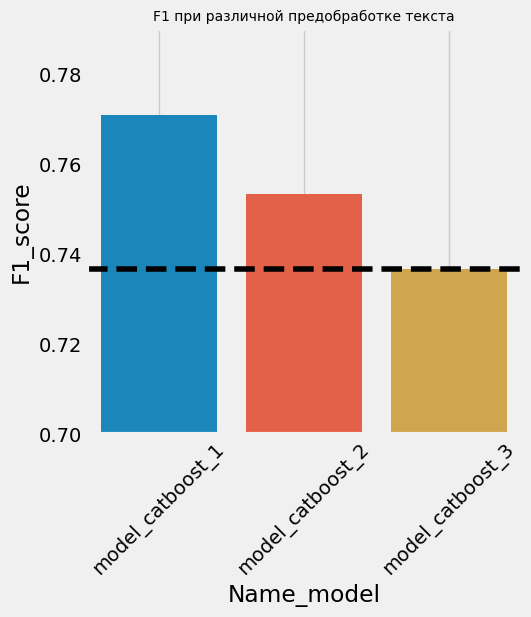

In [106]:
f1_catb = np.array([f1_score_catb_model_0, f1_score_catb_model_1, f1_score_catb_model_2])

df_catb = pd.DataFrame({'Name_model': ['model_catboost_1', 'model_catboost_2', 'model_catboost_3'],
                       'F1_score': f1_catb})

fig, ax = plt.subplots(figsize = (5, 5))
plt.ylim(0.7, 0.79)
sns.barplot(x='Name_model', y='F1_score', data=df_catb)
#ax.twinx()
plt.axhline(f1_catb.min(), color='black', linestyle='--')
# задаем ориентацию меток по оси x
plt.xticks(rotation=45)
plt.grid()
plt.title('F1 при различной предобработке текста', size=10)

Как видим из графика **Catboost**, гораздо лучше справляется с указанием текстовых и категориальных данных, чем со склееными данными и преобразованными в векторное пространство **TfIdf**

# Другие алгоритмы

## 1 Логистическая регрессия
Модель логистической регрессии выглядит следующим образом:
$$ f(x) = \frac{1} {1 + e ^{-(w \cdot x + b)}}$$

В случае мультклассовой задачи необходимо использовать softmax

In [111]:
# Импортируем библиотеку
from sklearn.linear_model import LogisticRegression

In [112]:
# Обучаем модель
logreg = LogisticRegression(n_jobs=3, C=1e5, solver='saga',
                                              multi_class= 'multinomial',
                                              max_iter = 1000,
                                              random_state = 7575)

logreg.fit(X_train, y_train)

LogisticRegression(C=100000.0, max_iter=1000, multi_class='multinomial',
                   n_jobs=3, random_state=7575, solver='saga')

In [113]:
# Посчитаем предсказанные значения на тестовой выборке
y_preds_logreg = logreg.predict(X_test)
print('Метод логистической регрессии')
print(classification_report(y_test, y_preds_logreg))
f1_score_logreg = f1_score(y_test, y_preds_logreg, average='weighted')
print(f'f1_score метода логистической регрессии равен {f1_score_logreg}')

Метод логистической регрессии
              precision    recall  f1-score   support

           1       0.78      0.81      0.79       685
           2       0.66      0.69      0.67       485
           3       0.68      0.48      0.56        96
           4       0.93      0.59      0.72        44

    accuracy                           0.73      1310
   macro avg       0.76      0.64      0.69      1310
weighted avg       0.73      0.73      0.73      1310

f1_score метода логистической регрессии равен 0.7293467744052189


## 3 Алгоритм случайного леса

В основе этого алгоритма лежит использование ансамбля решающих деревьев. Само по себе решающие деревья предоставляют невысокое качество классификации, но из-за большого количества результат улучшается

In [114]:
from sklearn.ensemble import RandomForestClassifier # импортируем необходимый класс изи библиотеки sklearn.ensemble

In [152]:
randomforest_model = RandomForestClassifier(max_depth=120, max_features=None, min_samples_leaf=4,
                       min_samples_split=7, n_estimators=100, criterion='gini')

randomforest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=120, max_features=None, min_samples_leaf=4,
                       min_samples_split=7)

In [153]:
# Посчитаем предсказанные значения на тестовой выборке
y_preds_randomforest = randomforest_model.predict(X_test)
print('Алгоритм случайного леса')
print(classification_report(y_test, y_preds_randomforest))
f1_score_randomforest = f1_score(y_test, y_preds_randomforest, average='weighted')
print(f'f1_score алгоритма случайного леса {f1_score_randomforest}')

Алгоритм случайного леса
              precision    recall  f1-score   support

           1       0.75      0.83      0.79       685
           2       0.68      0.59      0.63       485
           3       0.53      0.56      0.55        96
           4       1.00      0.55      0.71        44

    accuracy                           0.71      1310
   macro avg       0.74      0.63      0.67      1310
weighted avg       0.71      0.71      0.71      1310

f1_score алгоритма случайного леса 0.7093376050749889


# Эксперименты для алгоритма Наивного Байеса

In [166]:
df4 = df3.copy()
df4

,text_features,target
0,присылать анекдот предложить новость группа ре...,1
1,познавательный мем широкий охват уникальный ид...,1
2,хабра q a ответ любой тема it участник сообщес...,4
3,официальный канал сервис рбк инвестиция заботи...,3
4,помогать новичок веб разработчик опытный прогр...,4
...,...,...
4360,делиться новость происшествие жалоба предложен...,1
4361,пустой название юмор реально смешно,1
4362,доставлять сушить пицца wok ещ вкусненький ваш...,1
4363,внимание просить перевести студия карта мошенн...,1


In [189]:
from sklearn.feature_extraction.text import CountVectorizer




# Создадим корпус текста
corpus = df4['text_features'].values
# Используем векторизатор
count_vector = CountVectorizer()
# Трансформируем данные
model_vector = count_vector.fit_transform(corpus)

# Проведем разбивку на train и test
X_train, X_test, y_train, y_test = train_test_split(model_vector, df['target'].values, test_size=.3, 
                                                    random_state=7575, stratify =df['target'].values)


# Эксперимент CatBOOST countvectorizer

In [ ]:
# Обучаем модель
# Указываем на текстовые признаки
text_features = []
cat_features = []

# Обучаем модель
train_pool = Pool(
    X_train, y_train,
    text_features=text_features,
    cat_features=cat_features
)

validation_pool = Pool(
    X_test, y_test,
    text_features=text_features,
    cat_features=cat_features
)


print('Train dataset shape: {}\n'.format(train_pool.shape))
model_2_count= fit_model(train_pool, validation_pool)

Train dataset shape: (3055, 23464)

0:	learn: 0.5724259	test: 0.5513116	best: 0.5513116 (0)	total: 213ms	remaining: 17m 46s
100:	learn: 0.6627911	test: 0.6267183	best: 0.6305082 (99)	total: 5.52s	remaining: 4m 27s
200:	learn: 0.7184690	test: 0.6843186	best: 0.6843186 (193)	total: 10.6s	remaining: 4m 13s
300:	learn: 0.7407558	test: 0.6960545	best: 0.6965418 (293)	total: 15.6s	remaining: 4m 3s
400:	learn: 0.7621023	test: 0.7103057	best: 0.7109882 (395)	total: 20.3s	remaining: 3m 52s
500:	learn: 0.7770260	test: 0.7116560	best: 0.7153382 (451)	total: 24.6s	remaining: 3m 41s
600:	learn: 0.7862258	test: 0.7191819	best: 0.7198782 (567)	total: 28.8s	remaining: 3m 30s
700:	learn: 0.7969470	test: 0.7208686	best: 0.7215480 (639)	total: 33.4s	remaining: 3m 25s
800:	learn: 0.8034247	test: 0.7241394	best: 0.7260249 (758)	total: 37.6s	remaining: 3m 16s
900:	learn: 0.8079549	test: 0.7268682	best: 0.7293638 (883)	total: 41.8s	remaining: 3m 10s
1000:	learn: 0.8159962	test: 0.7246524	best: 0.7293638 (883

In [ ]:
# Посчитаем предсказанные значения на тестовой выборке
y_preds_catb_count = model_2_count.predict(X_test)
print('Модель со склееными текстовыми признаками')
print(classification_report(y_test, y_preds_catb_count))

## 4 Наивный байес

In [117]:
from sklearn.naive_bayes import MultinomialNB

In [118]:
baies_model = MultinomialNB()
baies_model.fit(X_train, y_train)

MultinomialNB()

In [190]:
# Напишем функцию для поиска параметра альфа. И отсортируем датафрейм
list_alpha = np.arange(1/100000, 20, 0.11)
f1_test_baies = np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    baies = MultinomialNB(alpha=alpha)
    baies.fit(X_train, y_train)
    from sklearn.metrics import f1_score
    f1_test_baies[count] = f1_score(y_test, baies.predict(X_test), average='weighted')
    count += 1

df_baies = pd.DataFrame({'alpha': list_alpha,
                         'f1_baies': f1_test_baies})
df_baies.sort_values('f1_baies', ascending=False)

,alpha,f1_baies
6,0.66001,0.706602
4,0.44001,0.701224
7,0.77001,0.700979
5,0.55001,0.700803
8,0.88001,0.699224
...,...,...
177,19.47001,0.590930
178,19.58001,0.589992
179,19.69001,0.589992
180,19.80001,0.589992


In [191]:
# Посчитаем предсказанные значения на тестовой выборке
y_preds_baies = baies_model.predict(X_test)
print('Алгоритм Байеса')
print(classification_report(y_test, y_preds_baies))
f1_score_baies = f1_score(y_test, y_preds_baies, average='weighted')
print(f'f1_score алгоритма Наивного байеса {f1_score_baies}')

Алгоритм Байеса
              precision    recall  f1-score   support

           1       0.66      0.91      0.77       685
           2       0.70      0.51      0.59       485
           3       0.58      0.07      0.13        96
           4       1.00      0.11      0.20        44

    accuracy                           0.67      1310
   macro avg       0.74      0.40      0.42      1310
weighted avg       0.68      0.67      0.64      1310

f1_score алгоритма Наивного байеса 0.6353079691774565


У алгоритма наивного Байеса нужно копать в сторону настройки гиперпараметров и распределения ngram

## 5 Метод k-ближайших соседей (K-Nearest Neighbors)

In [120]:
from sklearn.neighbors import KNeighborsClassifier # импортируем необходимый класс из библиотеки sklearn

В методе KNN выбор значения k очень важен. При маленьком значении k "шум" будет оказывать сильное воздействие на итоговый результат. Большое значение делает его затратным с точки зрения вычислений и противоречит основной идее KNN, что близкие точки могут иметь схожие плотности или классы. Значение по умолчанию для количества k-соседей - 5.

In [121]:
error_rate = []

for i in range(1,40):
    # создание KNN классификатора с заданным значением k
    knn = KNeighborsClassifier(n_neighbors = i)
    # обучение его на тренировочных данных
    knn.fit(X_train, y_train)
    # прогноз покупок на тестовых данных
    pred_i = knn.predict(X_test)
    # сохранение значения ошибки
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Процент ошибок')

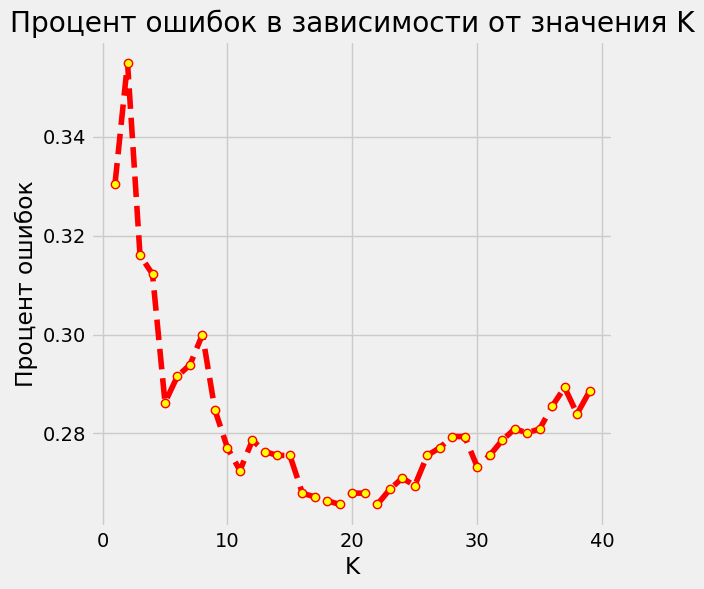

In [56]:
# графическое представление процента ошибок
plt.figure(figsize=(6,6))
plt.plot(range(1,40), error_rate, color='red', linestyle='dashed', marker='o', markerfacecolor='yellow', markersize=6)
plt.title('Процент ошибок в зависимости от значения K')
plt.xlabel('K')
plt.ylabel('Процент ошибок')

In [122]:
clf_knn = KNeighborsClassifier(n_neighbors=19) # создадим модель 5ти ближайших соседей
clf_knn.fit(X_train, y_train)  # оценим параметры модели
y_pred_knn = clf_knn.predict(X_test)  # прогноз отношения к классу 0 или 1

print('Алгоритм Ближайших соседей')
print(classification_report(y_test, y_pred_knn))
f1_score_knn = f1_score(y_test, y_pred_knn, average='weighted')
print(f'f1_score алгоритма Ближайших соседей {f1_score_knn}')

Алгоритм Ближайших соседей
              precision    recall  f1-score   support

           1       0.75      0.87      0.80       685
           2       0.71      0.63      0.67       485
           3       0.67      0.40      0.50        96
           4       0.90      0.59      0.71        44

    accuracy                           0.73      1310
   macro avg       0.75      0.62      0.67      1310
weighted avg       0.73      0.73      0.73      1310

f1_score алгоритма Ближайших соседей 0.7263267257822714


In [192]:
name_algo = ['catboost', 'naive_baies', 'logreg', 'randomforest', 'baies', 'knn']
f1_score = [f1_score_catb_model_0, 0.706, f1_score_logreg, f1_score_randomforest, f1_score_baies, f1_score_knn]

df_cls = pd.DataFrame({'name_algorithm' : name_algo,
                       'total_f1' : f1_score})

df_cls 

,name_algorithm,total_f1
0,catboost,0.770977
1,naive_baies,0.706000
2,logreg,0.729347
3,randomforest,0.709338
4,baies,0.635308
5,knn,0.726327


Text(0.5, 1.0, 'F1 при различных алгоритмах классификации')

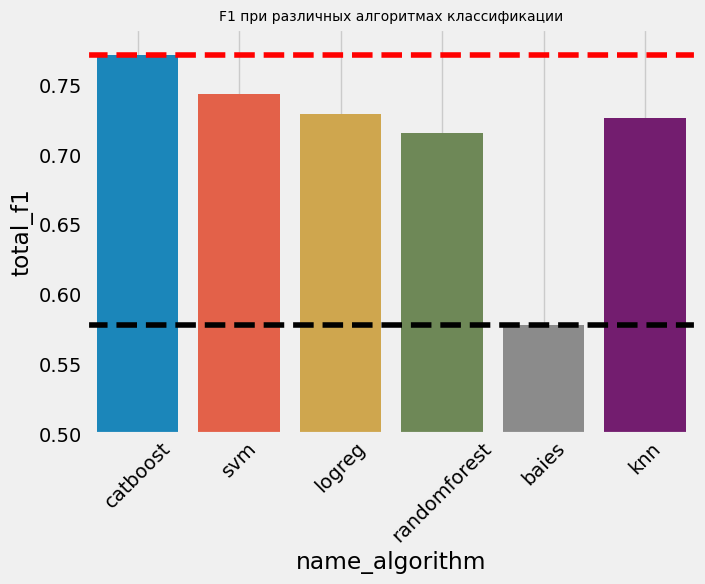

In [124]:
fig, ax = plt.subplots(figsize = (7, 5))
plt.ylim(0.5, 0.79)
sns.barplot(x='name_algorithm', y='total_f1', data=df_cls)
#ax.twinx()
plt.axhline(np.array(f1_score).min(), color='black', linestyle='--')
plt.axhline(np.array(f1_score).max(), color='red', linestyle='--')
# задаем ориентацию меток по оси x
plt.xticks(rotation=45)
plt.grid()
plt.title('F1 при различных алгоритмах классификации', size=10)

# Использование автоматической разметки с помощью тематического моделирования 

 Напишем функцию токенизации текста и применим ее к **df3**

In [125]:
def token(input_text):
    tokenized_text = word_tokenize(input_text)
    return tokenized_text

In [126]:
df3["new_processed"] = df3["text_features"].map(token)

In [127]:
df3.head(3)

,text_features,target,new_processed
0,присылать анекдот предложить новость группа ре...,1,"[присылать, анекдот, предложить, новость, груп..."
1,познавательный мем широкий охват уникальный ид...,1,"[познавательный, мем, широкий, охват, уникальн..."
2,хабра q a ответ любой тема it участник сообщес...,4,"[хабра, q, a, ответ, любой, тема, it, участник..."


### Создадим корпус в виде мешка слов

In [128]:
import gensim
 
gensim_dictionary = gensim.corpora.Dictionary(df3["new_processed"])
gensim_dictionary.filter_extremes(no_above=0.1, no_below=20)
gensim_dictionary.compactify()

In [129]:
corpus = [gensim_dictionary.doc2bow(text) 
          for text in df3['new_processed']]
# Выведем ряд значений
corpus[:1]

[[(0, 1),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1)]]

### Напишем функцию назначения метки наиболее вероятного топика

In [130]:
# Создаем модель тематического моделирования например из 4 топиков
lda = gensim.models.LdaMulticore(corpus, 
                                 num_topics=4, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=7575)

In [131]:
def get_topic(words, lda):
    """
    Функция назначает документу наиболее вероятный топик
    :param words: лемматизированный текст документа
    :param lda: тематическая модель
    :return: список из наиболее вероятного топика 
    и его вероятности
    """
    bag = lda.id2word.doc2bow(words)
    topics = lda.get_document_topics(bag)
    topic_dictionary = {}
    for topic in topics:
        topic_dictionary[topic[1]] = str((topic[0])) 
    main_probability = max(topic_dictionary)
    main_topic = topic_dictionary[main_probability]
    return main_topic

### Для каждого алгоритма выведем значения F1 при разных количествах тем

In [132]:
list_i_2 = []
list_svc_2 = []
list_logreg = []
list_randomforest = []
list_knn = []
list_catb= []
for i in range(3, 9):
    lda = gensim.models.LdaMulticore(corpus, 
                                 num_topics=i, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=7575)
    svm = SVC(probability=True, C=1, gamma=1, kernel='linear')
    # Применим функцию к датасету
    df3['new_target'] = df3["new_processed"].apply(get_topic, lda=lda)
    df3['new_target'] = df3['new_target'].astype('int')
    X_train, X_test, y_train, y_test = train_test_split(modeltf, df3['new_target'].values, test_size=.3, 
                                                    random_state=7575, stratify =df3['new_target'].values)
    # Обучаем модель SVM
    svm.fit(X_train, y_train)
    y_svm_pred = svm.predict(X_test)
    
    # Обучаем модель логрег
    logreg = LogisticRegression(n_jobs=3, C=1e5, solver='saga',
                                              multi_class= 'multinomial',
                                              max_iter = 1000,
                                              random_state = 7575)
    logreg.fit(X_train, y_train)
    y_logreg_pred = logreg.predict(X_test)
    
    # Обучаем KNN
    clf_knn = KNeighborsClassifier(n_neighbors=19) # создадим модель 5ти ближайших соседей
    clf_knn.fit(X_train, y_train)  # оценим параметры модели
    y_pred_knn = clf_knn.predict(X_test)
    
    # Обучаем Catboost
    # Указываем на текстовые признаки
    text_features = []
    cat_features = []

    # Обучаем модель
    train_pool = Pool(
        X_train, y_train,
        text_features=text_features,
        cat_features=cat_features
    )

    validation_pool = Pool(
        X_test, y_test,
        text_features=text_features,
        cat_features=cat_features
    )


    model_topic_catb = fit_model(train_pool, validation_pool)
    y_catb_pred = model_topic_catb.predict(X_test)
    
    from sklearn.metrics import f1_score
    # Добавляем в список оценки f1
    list_svc_2.append(f1_score(y_test, y_svm_pred, average='weighted'))
    list_i_2.append(i)
    list_logreg.append(f1_score(y_test, y_logreg_pred, average='weighted'))
    list_knn.append(f1_score(y_test, y_pred_knn, average='weighted'))
    list_catb.append(f1_score(y_test, y_catb_pred, average='weighted'))
    
df_topic = pd.DataFrame({'количество_тем': list_i_2,
                        'SVM': list_svc_2,
                        'logreg' : list_logreg,
                        'knn' : list_knn,
                        'catboost' : list_catb})

df_topic


0:	learn: 0.5374056	test: 0.5276788	best: 0.5276788 (0)	total: 249ms	remaining: 20m 45s
100:	learn: 0.6666994	test: 0.6311493	best: 0.6343679 (96)	total: 8.44s	remaining: 6m 49s
200:	learn: 0.7260407	test: 0.6775429	best: 0.6780587 (197)	total: 15.9s	remaining: 6m 18s
300:	learn: 0.7737005	test: 0.7219732	best: 0.7245754 (297)	total: 23s	remaining: 5m 59s
400:	learn: 0.8054423	test: 0.7456689	best: 0.7458046 (398)	total: 30.1s	remaining: 5m 45s
500:	learn: 0.8208279	test: 0.7526115	best: 0.7526619 (497)	total: 36.9s	remaining: 5m 31s
600:	learn: 0.8344277	test: 0.7627020	best: 0.7635513 (582)	total: 43.6s	remaining: 5m 19s
700:	learn: 0.8473642	test: 0.7782505	best: 0.7782505 (699)	total: 50.2s	remaining: 5m 7s
800:	learn: 0.8587556	test: 0.7807024	best: 0.7846391 (768)	total: 56.8s	remaining: 4m 57s
900:	learn: 0.8730433	test: 0.7817141	best: 0.7846391 (768)	total: 1m 3s	remaining: 4m 47s
1000:	learn: 0.8810603	test: 0.7872753	best: 0.7880102 (992)	total: 1m 9s	remaining: 4m 37s
1100:

3700:	learn: 0.9487932	test: 0.7767672	best: 0.7791721 (3653)	total: 4m 40s	remaining: 1m 38s
3800:	learn: 0.9517625	test: 0.7775221	best: 0.7791721 (3653)	total: 4m 47s	remaining: 1m 30s
3900:	learn: 0.9537110	test: 0.7799612	best: 0.7799612 (3855)	total: 4m 55s	remaining: 1m 23s
4000:	learn: 0.9550404	test: 0.7791436	best: 0.7807144 (3958)	total: 5m 2s	remaining: 1m 15s
4100:	learn: 0.9566637	test: 0.7799297	best: 0.7807144 (3958)	total: 5m 9s	remaining: 1m 7s
4200:	learn: 0.9573189	test: 0.7815364	best: 0.7815364 (4185)	total: 5m 16s	remaining: 1m
4300:	learn: 0.9586558	test: 0.7831714	best: 0.7831714 (4265)	total: 5m 23s	remaining: 52.6s
4400:	learn: 0.9599829	test: 0.7831714	best: 0.7831714 (4265)	total: 5m 30s	remaining: 45s
4500:	learn: 0.9626103	test: 0.7831151	best: 0.7839816 (4445)	total: 5m 37s	remaining: 37.5s
4600:	learn: 0.9649202	test: 0.7838700	best: 0.7839816 (4445)	total: 5m 44s	remaining: 29.9s
4700:	learn: 0.9659237	test: 0.7838700	best: 0.7839816 (4445)	total: 5m 5

2200:	learn: 0.8940100	test: 0.7194491	best: 0.7201256 (2177)	total: 4m 7s	remaining: 5m 14s
2300:	learn: 0.8986050	test: 0.7201788	best: 0.7225807 (2250)	total: 4m 17s	remaining: 5m 2s
2400:	learn: 0.9002508	test: 0.7217857	best: 0.7225807 (2250)	total: 4m 28s	remaining: 4m 50s
2500:	learn: 0.9045012	test: 0.7224393	best: 0.7225807 (2250)	total: 4m 38s	remaining: 4m 38s
2600:	learn: 0.9080864	test: 0.7217528	best: 0.7232922 (2503)	total: 4m 48s	remaining: 4m 26s
2700:	learn: 0.9097015	test: 0.7202445	best: 0.7232922 (2503)	total: 4m 58s	remaining: 4m 14s
2800:	learn: 0.9113610	test: 0.7217511	best: 0.7232922 (2503)	total: 5m 9s	remaining: 4m 2s
2900:	learn: 0.9136308	test: 0.7218453	best: 0.7233113 (2843)	total: 5m 19s	remaining: 3m 51s
3000:	learn: 0.9159066	test: 0.7225114	best: 0.7233113 (2843)	total: 5m 29s	remaining: 3m 39s
3100:	learn: 0.9178553	test: 0.7240381	best: 0.7247655 (3075)	total: 5m 39s	remaining: 3m 28s
3200:	learn: 0.9214518	test: 0.7248142	best: 0.7255802 (3166)	to

700:	learn: 0.7561175	test: 0.6284039	best: 0.6285342 (696)	total: 1m 55s	remaining: 11m 49s
800:	learn: 0.7725090	test: 0.6416558	best: 0.6424938 (795)	total: 2m 11s	remaining: 11m 27s
900:	learn: 0.7849025	test: 0.6539472	best: 0.6541123 (893)	total: 2m 27s	remaining: 11m 8s
1000:	learn: 0.7956286	test: 0.6582807	best: 0.6611726 (985)	total: 2m 42s	remaining: 10m 48s
1100:	learn: 0.8108469	test: 0.6646791	best: 0.6662722 (1092)	total: 2m 57s	remaining: 10m 29s
1200:	learn: 0.8195508	test: 0.6678459	best: 0.6700710 (1171)	total: 3m 12s	remaining: 10m 10s
1300:	learn: 0.8277911	test: 0.6681512	best: 0.6705028 (1247)	total: 3m 27s	remaining: 9m 50s
1400:	learn: 0.8347117	test: 0.6717895	best: 0.6726047 (1357)	total: 3m 42s	remaining: 9m 30s
1500:	learn: 0.8398498	test: 0.6756820	best: 0.6772875 (1494)	total: 3m 56s	remaining: 9m 11s
1600:	learn: 0.8457620	test: 0.6781488	best: 0.6795848 (1570)	total: 4m 11s	remaining: 8m 53s
1700:	learn: 0.8510522	test: 0.6765261	best: 0.6795848 (1570)	

,количество_тем,SVM,logreg,knn,catboost
0,3,0.876761,0.856381,0.803785,0.814515
1,4,0.829263,0.848506,0.756301,0.785461
2,5,0.796141,0.800832,0.736424,0.753913
3,6,0.765622,0.779337,0.648797,0.730360
4,7,0.757666,0.761718,0.646847,0.698528
5,8,0.722256,0.731600,0.632749,0.698515


### Определим метрику F1 при разных количествах тем для групп. Результат сведем в таблицу

In [133]:
catboost_top = []
list_iter_cat = []
for i in range(3, 9):
    lda = gensim.models.LdaMulticore(corpus, 
                                 num_topics=i, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=7575)
    svm = SVC(probability=True, C=1, gamma=1, kernel='linear')
    # Применим функцию к датасету
    df3['new_target'] = df3["new_processed"].apply(get_topic, lda=lda)
    df3['new_target'] = df3['new_target'].astype('int')

    df2['target'] = df3['new_target']
    X_train, X_test, y_train, y_test = train_test_split(df2.drop('target', axis=1), 
                                                    df2['target'], test_size=.3, 
                                                    random_state=7575)
    # Указываем признаки
    # Текстовые и категориальные признаки
    text_features = ['description_processed','name_processed']
    cat_features = ['activity_processed']

    train_pool = Pool(
    X_train, y_train,
    text_features=text_features,
    cat_features=cat_features
    )

    validation_pool = Pool(
    X_test, y_test,
    text_features=text_features,
    cat_features=cat_features
    )

    model_catb = fit_model(train_pool, validation_pool)
    y_catb_pred = model_catb.predict(X_test)
    from sklearn.metrics import f1_score
    # Добавляем в список оценки f1
    catboost_top.append(f1_score(y_test, y_catb_pred, average='weighted'))
    list_iter_cat.append(i)
    
df_cat = pd.DataFrame({'количество_тем': list_iter_cat,
                        'catboost_no_TFIDF': catboost_top})

df_cat

0:	learn: 0.7356356	test: 0.7432898	best: 0.7432898 (0)	total: 41.6ms	remaining: 3m 28s
100:	learn: 0.7807293	test: 0.7862391	best: 0.7870213 (94)	total: 3.21s	remaining: 2m 35s
200:	learn: 0.7897384	test: 0.7873383	best: 0.7873383 (198)	total: 6.09s	remaining: 2m 25s
300:	learn: 0.8154450	test: 0.8028613	best: 0.8036432 (298)	total: 8.51s	remaining: 2m 12s
400:	learn: 0.8197806	test: 0.8044700	best: 0.8059847 (381)	total: 10.7s	remaining: 2m 2s
500:	learn: 0.8240239	test: 0.8044526	best: 0.8059847 (381)	total: 12.8s	remaining: 1m 55s
600:	learn: 0.8272748	test: 0.8052077	best: 0.8059847 (381)	total: 15s	remaining: 1m 50s
700:	learn: 0.8308541	test: 0.8059456	best: 0.8059847 (381)	total: 17.2s	remaining: 1m 45s
800:	learn: 0.8308673	test: 0.8082502	best: 0.8082502 (766)	total: 19.3s	remaining: 1m 41s
900:	learn: 0.8334764	test: 0.8090294	best: 0.8097830 (896)	total: 21.4s	remaining: 1m 37s
1000:	learn: 0.8350785	test: 0.8105819	best: 0.8105819 (931)	total: 23.6s	remaining: 1m 34s
1100:

3800:	learn: 0.8805145	test: 0.7709010	best: 0.7748177 (3671)	total: 1m 42s	remaining: 32.3s
3900:	learn: 0.8834989	test: 0.7709010	best: 0.7748177 (3671)	total: 1m 44s	remaining: 29.5s
4000:	learn: 0.8858528	test: 0.7716710	best: 0.7748177 (3671)	total: 1m 47s	remaining: 26.8s
4100:	learn: 0.8871760	test: 0.7724788	best: 0.7748177 (3671)	total: 1m 50s	remaining: 24.1s
4200:	learn: 0.8884936	test: 0.7702311	best: 0.7748177 (3671)	total: 1m 52s	remaining: 21.4s
4300:	learn: 0.8901606	test: 0.7701765	best: 0.7748177 (3671)	total: 1m 55s	remaining: 18.7s
4400:	learn: 0.8918537	test: 0.7693818	best: 0.7748177 (3671)	total: 1m 57s	remaining: 16s
4500:	learn: 0.8938388	test: 0.7693818	best: 0.7748177 (3671)	total: 2m	remaining: 13.4s
4600:	learn: 0.8961757	test: 0.7686659	best: 0.7748177 (3671)	total: 2m 3s	remaining: 10.7s
4700:	learn: 0.8981552	test: 0.7709783	best: 0.7748177 (3671)	total: 2m 5s	remaining: 7.99s
4800:	learn: 0.8997978	test: 0.7718230	best: 0.7748177 (3671)	total: 2m 8s	rem

2400:	learn: 0.7933445	test: 0.6715397	best: 0.6754354 (2055)	total: 1m 22s	remaining: 1m 29s
2500:	learn: 0.7956723	test: 0.6730276	best: 0.6754354 (2055)	total: 1m 25s	remaining: 1m 25s
2600:	learn: 0.7983320	test: 0.6731282	best: 0.6754354 (2055)	total: 1m 28s	remaining: 1m 21s
2700:	learn: 0.8045788	test: 0.6730016	best: 0.6754354 (2055)	total: 1m 32s	remaining: 1m 18s
2800:	learn: 0.8055665	test: 0.6738613	best: 0.6754354 (2055)	total: 1m 35s	remaining: 1m 14s
2900:	learn: 0.8091517	test: 0.6722668	best: 0.6754354 (2055)	total: 1m 38s	remaining: 1m 11s
3000:	learn: 0.8131019	test: 0.6722303	best: 0.6754354 (2055)	total: 1m 41s	remaining: 1m 7s
3100:	learn: 0.8151003	test: 0.6723103	best: 0.6754354 (2055)	total: 1m 44s	remaining: 1m 4s
3200:	learn: 0.8194661	test: 0.6728493	best: 0.6754354 (2055)	total: 1m 47s	remaining: 1m
3300:	learn: 0.8221324	test: 0.6738699	best: 0.6754354 (2055)	total: 1m 51s	remaining: 57.2s
3400:	learn: 0.8251502	test: 0.6746964	best: 0.6754354 (2055)	total

900:	learn: 0.7271508	test: 0.6466904	best: 0.6474548 (887)	total: 43.5s	remaining: 3m 17s
1000:	learn: 0.7314921	test: 0.6466196	best: 0.6474971 (913)	total: 47.4s	remaining: 3m 9s
1100:	learn: 0.7376048	test: 0.6490466	best: 0.6505763 (1065)	total: 51.3s	remaining: 3m 1s
1200:	learn: 0.7455434	test: 0.6490349	best: 0.6505763 (1065)	total: 55.4s	remaining: 2m 55s
1300:	learn: 0.7491870	test: 0.6504411	best: 0.6512228 (1276)	total: 59.3s	remaining: 2m 48s
1400:	learn: 0.7537655	test: 0.6505300	best: 0.6519311 (1320)	total: 1m 3s	remaining: 2m 42s
1500:	learn: 0.7599734	test: 0.6497514	best: 0.6519311 (1320)	total: 1m 7s	remaining: 2m 36s
1600:	learn: 0.7652576	test: 0.6518501	best: 0.6526913 (1577)	total: 1m 11s	remaining: 2m 31s
1700:	learn: 0.7698039	test: 0.6502713	best: 0.6526913 (1577)	total: 1m 15s	remaining: 2m 25s
1800:	learn: 0.7760727	test: 0.6510534	best: 0.6526913 (1577)	total: 1m 19s	remaining: 2m 20s
1900:	learn: 0.7826074	test: 0.6526487	best: 0.6526913 (1577)	total: 1m 

,количество_тем,catboost_no_TFIDF
0,3,0.812924
1,4,0.774818
2,5,0.726434
3,6,0.697634
4,7,0.660849
5,8,0.667193


### Соберем датафрейм с результататами

In [142]:
df_result = pd.concat([df_topic, df_cat['catboost_no_TFIDF']], axis=1)
df_result

,количество_тем,SVM,logreg,knn,catboost,catboost_no_TFIDF
0,3,0.876761,0.856381,0.803785,0.814515,0.812924
1,4,0.829263,0.848506,0.756301,0.785461,0.774818
2,5,0.796141,0.800832,0.736424,0.753913,0.726434
3,6,0.765622,0.779337,0.648797,0.730360,0.697634
4,7,0.757666,0.761718,0.646847,0.698528,0.660849
5,8,0.722256,0.731600,0.632749,0.698515,0.667193


### Выводы 11.03.23:

1. Не смотря на то, что Catboost имеет встроенный алгоритм обработки текста. Результаты показывают, что он не самый лучший по выбранной метрике. Возможно следует лучше подбирать гиперпараметры.
2. Алгоритм случайного леса не участвовал, в сравнении метрики F1. Так как достаточно долго считается. 
3. Тематическое моделирование проводилось в рамках эксперимента, так как после создания классификатора по текстам, будет создаваться бинарный классификатор уже для user_id и по этому классификатору уже можно отслеживать какое количество разбиений наиболее оптимально.
4. Начал писать классификатор по Берту. Также хочу включить его в эксперимент по метрике F1.
5. Сокращения типа **Q&A** на данный момент не почищены. Чистить буду путем replace список русско-английских сокращений будет взят с помощью **ChatGPT**
6. CatBOOST хорошо работает без преобразования в векторное пространство.
7. Naive Baies показал по дефолту 0.58, при использовании countvectorizer 0.7, tf_idf vectorizer 0.67

**Последующие стадии работы**
Очистить датасет для бинарной классификации. "пригоден не пригоден" для учебы "прикладная информатика". Желательно исключить `nan` по половому признаку, так как пол скорее всего будет хорошо влиять на предсказание. Сделать сбалансированные выборки. Провести эксперимент с тремя алгоритмами градиентного бустинга CatBoost, LightGBM, XGBBoost.

Улучшить результаты с помощью перекрестной кроссвалидации.

результаты по предсказанию метки текста можно улучшить с помощью бленденга(смешивания моделей). Результат на данный момент себя не включил, разбираюсь.  


###  Выводы (3.03.23)
1. Большая сложность возникает в моменте экспертной оценке. Необходимо быть предельно внимательным при оценке. При проставленной оценке легче обнаружить ошибки
2. Нужна большая степень очистки текста (в этом моменте все пересмотреть)
3. На данный момент сделана простейшая классификация, для улучшения модели можно сделать поиск гиперпараметров (grid search, optuna). Перекрестная кросс-валидация.
4. Но на мой взгляд, для улушения качества классификации нужно еще раз пересмотреть разметку. Так как одинаковые метки могут иметь разные баллы и делать более четкое соотношение. Также можно попробовать переразметить для балансировки классов.
5. Текст имеет неоднородную структуру. Разная длина, есть пустые значения. Разный язык, попадался английский, арабский...
Поэтому модель трансформеров, скорее всего не подойдет или на данный момент пока непонятно, какую предоубученную модель у трансформеров использовать.


### Дальнейшие шаги
1. Проверка разметки. Проверка чистки данных.
2. Предсказанные отметки пойдут во вторую модель для бинарной классификации подходит абитуриент для " Прикладной математики или нет"
3. Также необходимо протестировать модели бинарной классификации на оценках полученных при помощи разметки и при помощи тематического моделирования. Если данные четко почистить, то вероятно соотношение классов будет лучше. То есть юмор с юмором, программирование с математикой итд.